In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)
piyg = cm.get_cmap('PiYG', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

import glob
import root_pandas
from scipy.optimize import curve_fit

import misc_util

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.22/06


In [2]:
#data_dihadrons =  uproot3.open('../in/data_dihadrons_100pc.root')['dihadrons'].pandas.df()

In [3]:
data_dihadrons = root_pandas.read_root(glob.glob('/home/sebouh/tuples_hadd/*_dihadrons*.root'))

In [4]:
print(len(data_dihadrons))

28560723


In [5]:
#obtains the 1d asymmetry function.  Does not plot it.  
def asym1d(df,bins=25,scale=1):
    yp,x = np.histogram(df.query('helicity>0').diff_phi_cm,bins=bins, range=(-np.pi,np.pi))
    ym,x = np.histogram(df.query('helicity<0').diff_phi_cm,bins=bins, range=(-np.pi,np.pi))
    x = pd.Series([(x[i] + x[i+1])/2 for i in range(len(x)-1)])

    tot = yp+ym
    a = (yp-ym)*scale/(tot+(tot==0)*1)
    da = (np.sqrt((1-a**2)/(tot+(tot==0)*1))+(tot==0)*1)*scale
    return x,a,da


In [24]:


from scipy.optimize import curve_fit

def sin2phifit(x,y,dy):
    def f (xx,a0,b1,b2):
        return a0+b1*np.sin(xx)+b2*np.sin(2*xx)
    p,cov = curve_fit(f, x, y,sigma=dy)
    return p,cov
def altfit(x,y,dy):
    def f (xx,a0,b1,b2):
        return a0+b1*np.sin(xx)/(1+b2*np.cos(xx))
    p,cov = curve_fit(f, x, y,sigma=dy)
    return p,cov

In [39]:
def asym2d(df,bins=25,scale=1,yrange=(0, 2.5)):
    dfp = df.query('helicity>0')
    yp, xedges, yedges = np.histogram2d(dfp.diff_rap_cm,dfp.diff_phi_cm,bins=bins, range=[yrange,(-np.pi,np.pi)])
    dfm = df.query('helicity<0')
    ym, xedges, yedges = np.histogram2d(dfm.diff_rap_cm,dfm.diff_phi_cm,bins=bins, range=[yrange,(-np.pi,np.pi)])
    
    tot = yp+ym
    a = (yp-ym)*scale/tot
    da = np.sqrt((1-a**2)/tot)*scale
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    return xpos,ypos,a,da

def plotasym2d(xpos,ypos,a,min_highlight=1.5,zrange=0.03,label="",scale=1, ax1=None):
    if ax1 is None:
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(111, projection='3d')
    elev = 70
    azim = -112.5#-135
    ax1.view_init(azim=azim,elev = elev)
    #for i in range(len(xpos[0])-1):
    #    if(xpos[0][i]>min_highlight):
    #        break
    #ax1.plot_surface(xpos.transpose()[:i+1].transpose(), ypos.transpose()[:i+1].transpose(), a[:i+1].transpose(), cmap=viridis,edgecolor='k')
    #ax1.plot_surface(xpos.transpose()[i:].transpose(), ypos.transpose()[i:].transpose(), a[i:].transpose(), cmap=autumn,edgecolor='k')
    
    
    a = a*((a>-zrange)&(a<zrange))-(a<-zrange)*zrange+(a>zrange)*zrange
    ax1.plot_surface(xpos.transpose().transpose(), ypos.transpose().transpose(), a.transpose(), cmap=piyg,edgecolor='k')
    
    ax1.set_xlabel("$\\Delta y$",fontsize='large')
    ax1.set_ylabel("$\\Delta\\phi$ [rad]",fontsize='large')
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlim(-zrange,zrange)
    ax1.set_title("$A_{%s}(\\Delta\\phi,\\Delta y)$" % label,rotation=0)
    
                                        

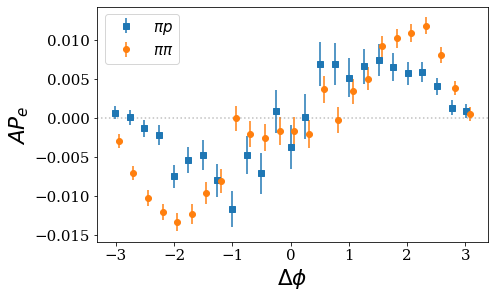

In [7]:
bins = 25

x,a,da= asym1d(data_dihadrons.query('h2_pid==2212'),scale=1/.863)
plt.errorbar(x,a, da, linestyle='',label='$\pi p$',marker='s')

x,a,da= asym1d(data_dihadrons.query('abs(h2_pid)==211'),scale=1/.863)
plt.errorbar(x+(x[1]-x[0])/4,a, da, linestyle='',label='$\pi\pi$',marker='o')

plt.axhline(0,linestyle=':',alpha=0.5,color="0.5")
plt.ylabel("$AP_e$")
plt.xlabel("$\Delta\phi$")
plt.legend(loc='upper left')
plt.savefig("../images/helicity_asymmetry.pdf",bbox_inches='tight')

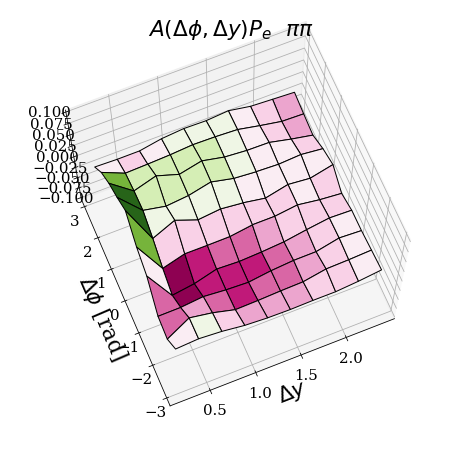

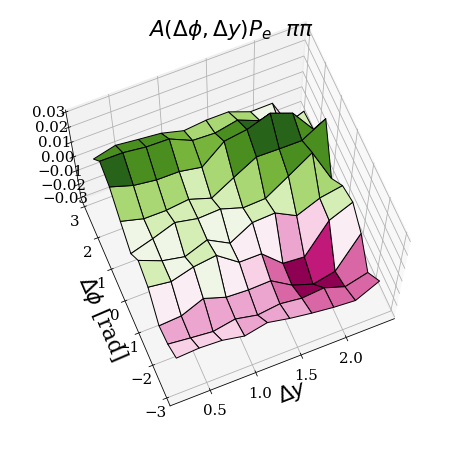

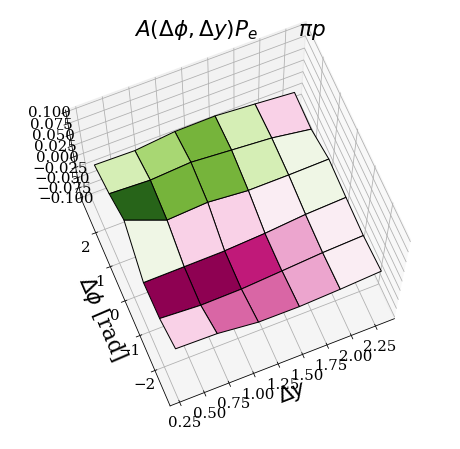

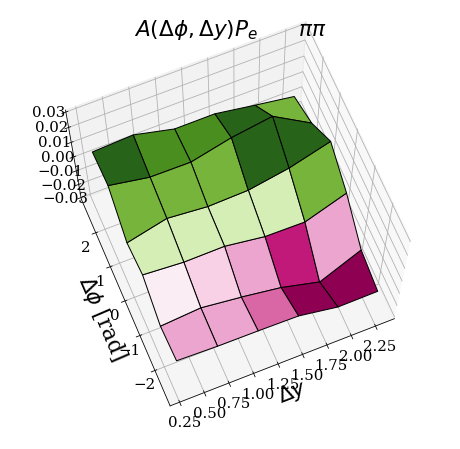

In [14]:
args = dict(yrange=(0.1,2.5),bins=10,scale=1/.863)

xpos,ypos,a,da= asym2d(data_dihadrons.query('h2_pid==2212 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'),
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10,zrange=0.1, label ="$\pi\pi$")

plt.savefig("../images/asym2d_pi_p_10bins.pdf")
xpos,ypos,a,da= asym2d(data_dihadrons.query('abs(h2_pid)==211 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'),
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10, label ="$\pi\pi$")

plt.savefig("../images/asym2d_pi_pi_10bins.pdf")

args = dict(yrange=(0.1,2.5),bins=6,scale=1/.863)
xpos,ypos,a,da= asym2d(data_dihadrons.query('h2_pid==2212 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1 '),
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10,zrange=0.1, label ="    $\pi p$")

plt.savefig("../images/asym2d_pi_p_6bins.pdf")
xpos,ypos,a,da= asym2d(data_dihadrons.query('abs(h2_pid)==211 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'),
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10, label ="    $\pi\pi$")

plt.savefig("../images/asym2d_pi_pi_6bins.pdf")

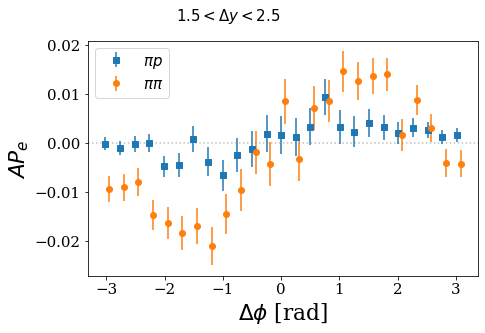

In [8]:
bins = 25

x,a,da= asym1d(data_dihadrons.query('h2_pid==2212 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'))
plt.errorbar(x,a, da, linestyle='',label='$\pi p$',marker='s')

x,a,da= asym1d(data_dihadrons.query('abs(h2_pid)==211 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'))
plt.errorbar(x+(x[1]-x[0])/4,a, da, linestyle='',label='$\pi\pi$',marker='o')

plt.axhline(0,linestyle=':',alpha=0.5,color="0.5")
plt.ylabel("$AP_e$")
plt.xlabel("$\Delta\phi$ [rad]")
plt.legend(loc='upper left')
plt.text(-1.8, 0.025, "$1.5<\Delta y < 2.5$")
plt.savefig("../images/asym1d_high_rap_separation.pdf",bbox_inches='tight')

<ipython-input-56-d0944aa16a16>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


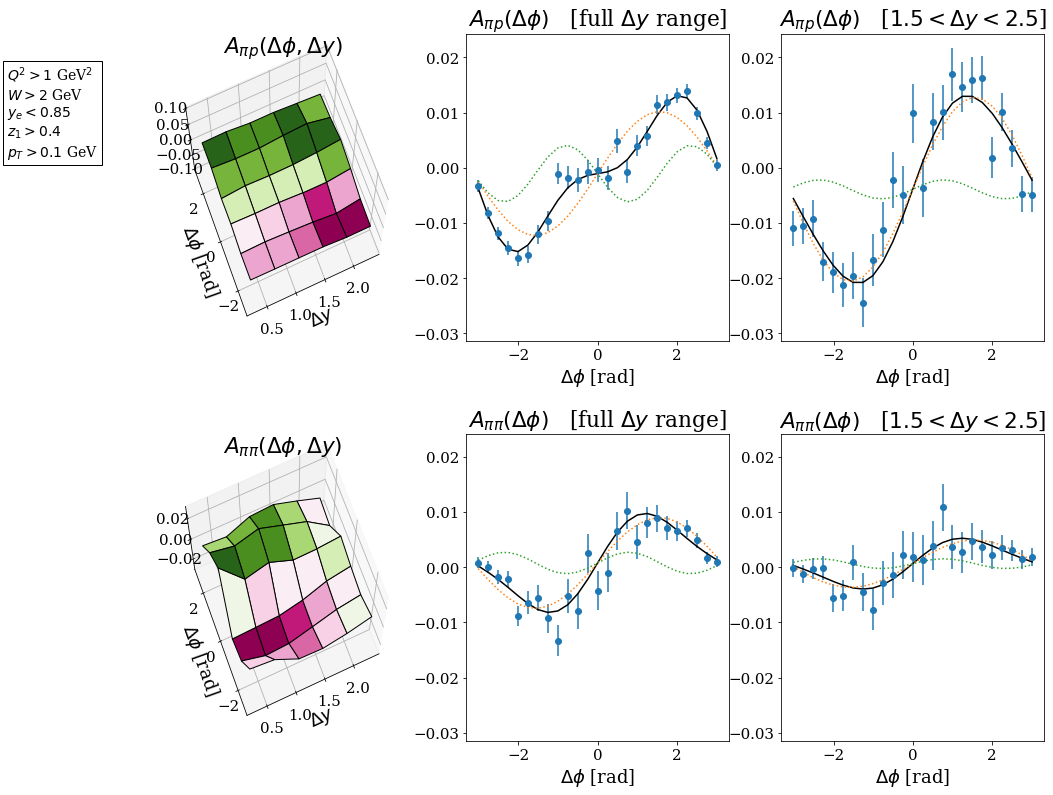

In [56]:
dfs = [data_dihadrons.query('h1_cm_pt > 0.1 and h2_cm_pt > 0.1').query(q) for q in 'abs(h2_pid)==211 h2_pid==2212'.split()]

fig = plt.figure(figsize=(16,13))
fig.subplots_adjust(hspace=0.3)
args = dict(yrange=(0.1,2.5),bins=6,scale=1/.863)
xpos,ypos,a,da= asym2d(dfs[0],
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10,zrange=0.1, label ="\pi p",ax1=fig.add_subplot(231, projection='3d'))

xpos,ypos,a,da= asym2d(dfs[1],
                       **args)
plotasym2d(xpos,ypos,a,min_highlight=10, label ="\pi\pi",ax1=fig.add_subplot(234, projection='3d'))

def tmp(ax,df,l1,l2):
    x,a,da= asym1d(df,scale=1/.863)
    ax.errorbar(x,a, da, linestyle='',label='$\pi p$',marker='o')
    (p0,p1,p2),cov = sin2phifit(x,a,da)
    ax.set_title("$A_{%s}(\\Delta\phi)$   [%s]" %(l1,l2))
    ax.plot(x,p0+p1*np.sin(x)+p2*np.sin(2*x),linestyle='-',color='k')
    ax.plot(x,p0+p1*np.sin(x),linestyle=':')
    ax.plot(x,p0+p2*np.sin(2*x),linestyle=':')
    ax.set_xlabel("$\\Delta\\phi$ [rad]",fontsize='large')
    #ax.axhline(0,color='0.7',linestyle=':')

ax2=fig.add_subplot(232)
tmp(ax2,dfs[0],"\pi p","full $\\Delta y$ range")

ax3=fig.add_subplot(233, sharey = ax2)
tmp(ax3,dfs[0].query("diff_rap_cm>1.5 and diff_rap_cm<2.5"),"\\pi p","$1.5<\\Delta y<2.5$")

ax5=fig.add_subplot(235, sharey = ax2)
tmp(ax5,dfs[1],"\pi\pi","full $\\Delta y$ range")

ax6=fig.add_subplot(236, sharey = ax2)
tmp(ax6,dfs[1].query("diff_rap_cm>1.5 and diff_rap_cm<2.5"),"\\pi\\pi","$1.5<\\Delta y<2.5$")

fig.subplots_adjust(hspace=0.3)

fig.text(0,0.75,"$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$\n$z_1>0.4$\n$p_T>0.1$ GeV",
         bbox=dict(facecolor='white', alpha=1),fontsize=14)

fig.savefig("../images/helicity.pdf",bbox_inches='tight')
fig.show()

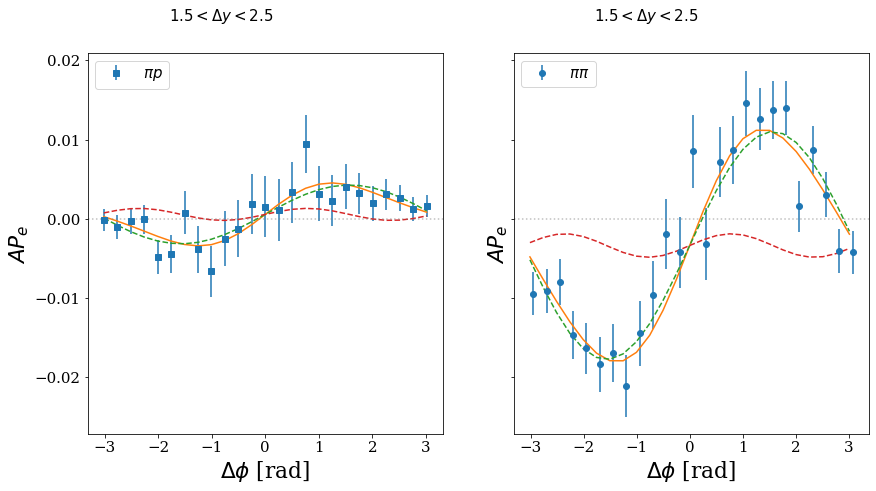

In [26]:
bins = 25
fig,axs = plt.subplots(1,2, figsize=(14,7),sharey='all')
x,a,da= asym1d(data_dihadrons.query('h2_pid==2212 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'))
axs[0].errorbar(x,a, da, linestyle='',label='$\pi p$',marker='s')
(p0,p1,p2),cov = sin2phifit(x,a,da)
axs[0].plot(x,p0+p1*np.sin(x)+p2*np.sin(2*x),linestyle='-')
axs[0].plot(x,p0+p1*np.sin(x),linestyle='--')
axs[0].plot(x,p0+p2*np.sin(2*x),linestyle='--')

x,a,da= asym1d(data_dihadrons.query('abs(h2_pid)==211 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1'))
axs[1].errorbar(x+(x[1]-x[0])/4,a, da, linestyle='',label='$\pi\pi$',marker='o')
(p0,p1,p2),cov = sin2phifit(x,a,da)
axs[1].plot(x,p0+p1*np.sin(x)+p2*np.sin(2*x),linestyle='-')
axs[1].plot(x,p0+p1*np.sin(x),linestyle='--')
axs[1].plot(x,p0+p2*np.sin(2*x),linestyle='--')

for ax in axs:
    ax.axhline(0,linestyle=':',alpha=0.5,color="0.5")
    ax.set_ylabel("$AP_e$")
    ax.set_xlabel("$\Delta\phi$ [rad]")
    ax.legend(loc='upper left')
    ax.text(-1.8, 0.025, "$1.5<\Delta y < 2.5$")
plt.savefig("../images/asym1d_high_rap_separation.pdf",bbox_inches='tight')

Help on class BinIterator in module misc_util:

class BinIterator(builtins.object)
 |  BinIterator(df, xvar, min, max, bins, mode='df')
 |  
 |  #mode options are
 |  # df:  return the slice dataframes (default)
 |  # len: return the numbers of entries in each slice
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df, xvar, min, max, bins, mode='df')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

-0.008043081530104544 1.0368088294410745e-06
0.0033806970766938464 2.0595574710806203e-06
0.017364709772972036 5.07960635305025e-06
0.03720129329145735 1.5005285638976194e-05
0.041080066481080584 2.419481802021773e-05
0.056963019826770954 5.909670746023

<ipython-input-27-8b68c93205f8>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


-0.012094788922278013 5.618527331079922e-06
-0.00639738173476427 8.988601317186721e-07
0.004966183909018349 1.1207819902670445e-06
0.021739410804014817 3.50177435303909e-06
0.04061358922385281 1.2115622677656006e-05
0.04504381426146766 8.334789397570596e-05
0.07941568682645406 0.0006620914660037644


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.0 inf
0.0 0.0
0.03180030183343157 8.134429297541845e-06
0.02846226786200453 4.899910353354345e-06
-0.0024883271754681142 5.74862181155603e-06
-0.016563542653636458 8.236662233202495e-06
-0.017961922862029436 3.082873369450855e-05
-0.047342378706311646 0.00012259830590277592
-0.09413484154057518 0.0008160229217549946
0.0 0.0
0.0 0.0


<ipython-input-27-8b68c93205f8>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


0.0026156992570620105 3.550355758241583e-06
0.007468376099673853 3.2351617149185875e-06
0.0014227277331715629 1.873919880887369e-06
0.0029426227689003277 6.805059372523174e-06
0.00024535824529333473 8.428606783779114e-06
0.002680116709652156 2.330947177026259e-05
-0.005372079823393917 2.266644340368946e-05
-0.010342357635402902 0.00018164012559326783
0.04144293021760853 0.0005851960791717805
0.016384985433974937 4.333606214107548e-06
0.018461784708462912 4.092100559827105e-06
0.01195313873100567 1.0845518600261357e-05
0.010387151407615241 8.148741602638222e-06
0.004947594476238866 4.8550742074433465e-05
-0.0018821967245597115 7.276435612193692e-05
-0.020393337050751446 0.0002903132378729822
-0.044861126460297066 0.00031359094509029496
-0.056663142569184366 0.0018860947162598614


<ipython-input-27-8b68c93205f8>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


0.014710322193062501 6.407234848473702e-06
0.005501405829899147 2.26568118871344e-06
-0.002528336678883802 1.0516733856865805e-06
-0.002778533123055868 2.9236565673508755e-06
-0.0030415335316076124 5.593375732115399e-06
0.01246595494051562 5.996515869346172e-06
0.03287510825656278 3.112345973047031e-05
0.05438034757674903 0.00011639748000787835
0.07224041613893073 0.0002249247240112332
0.02027303481134131 3.713435585232092e-05
0.01754644325509221 1.0420103213981241e-05
0.017763794410366438 4.072791999926657e-06
0.01278319732106414 2.7023785134725945e-06
0.011158410533708885 4.20097056751249e-06
0.008393438786553667 2.3127473760721023e-05
-0.00154258789998325 3.2141175432091566e-05
-0.0175167423202879 0.00026490886485171596
-0.06205504337737273 0.0010051020994001768


<ipython-input-27-8b68c93205f8>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-27-8b68c93205f8>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


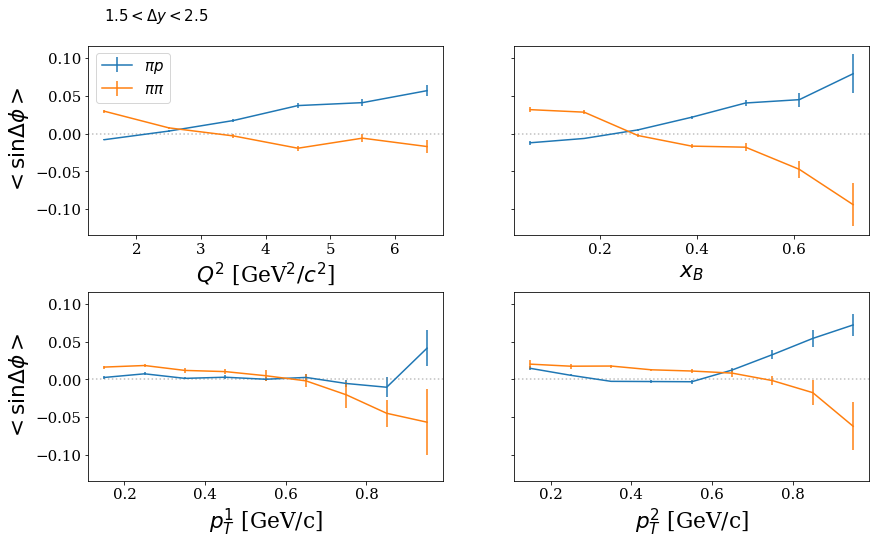

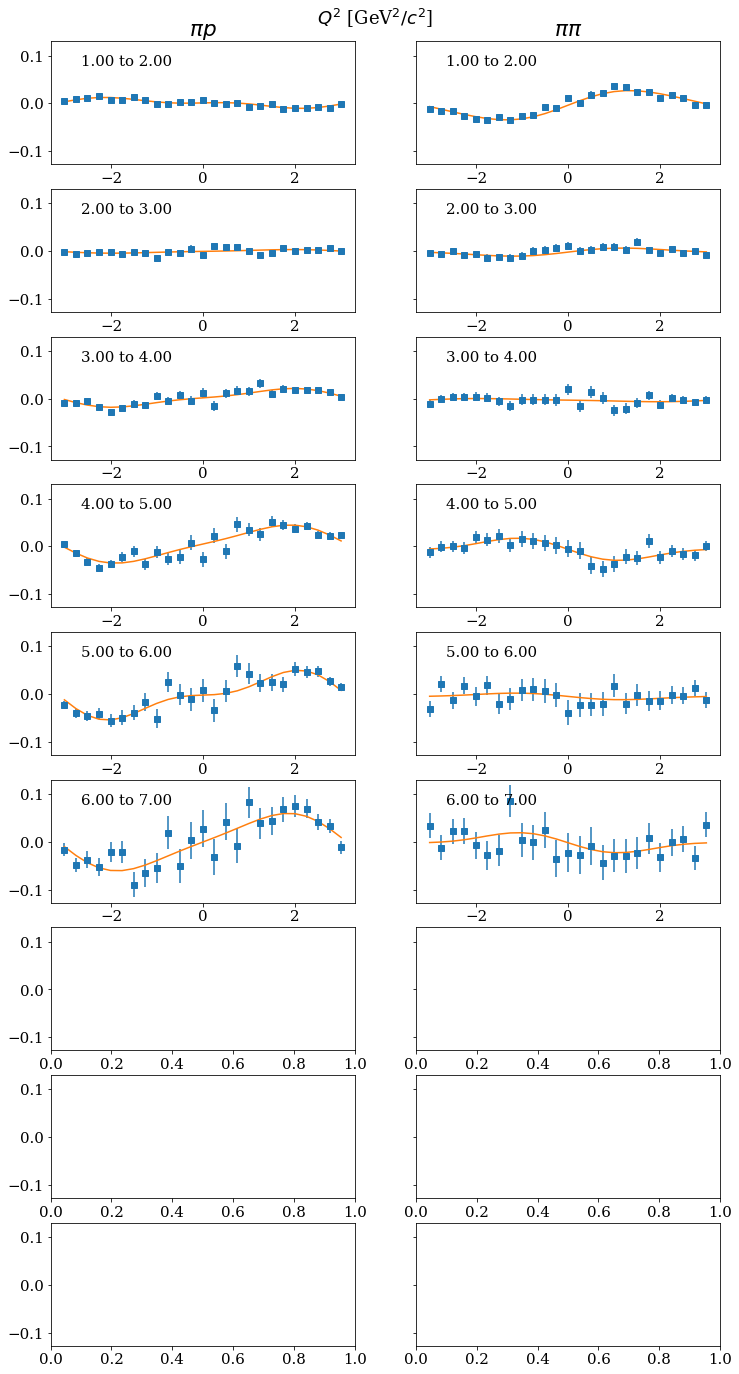

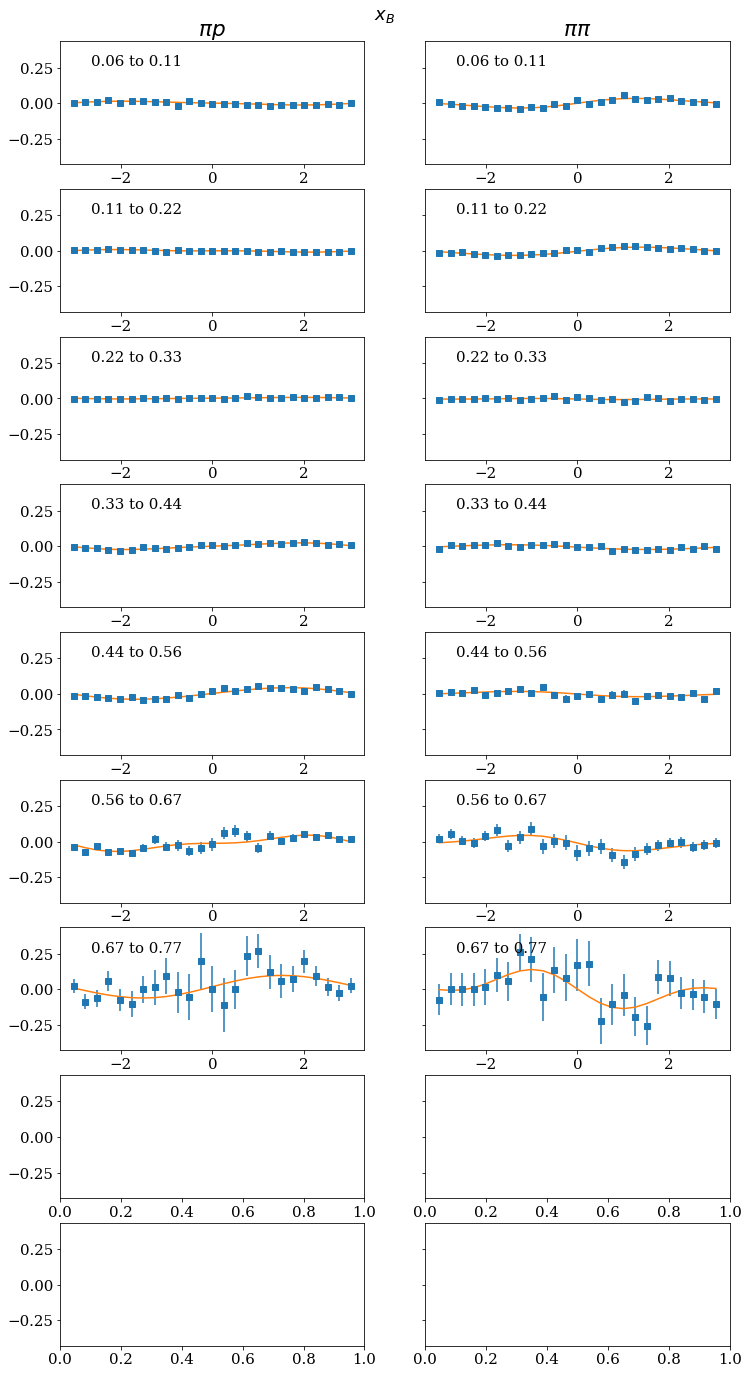

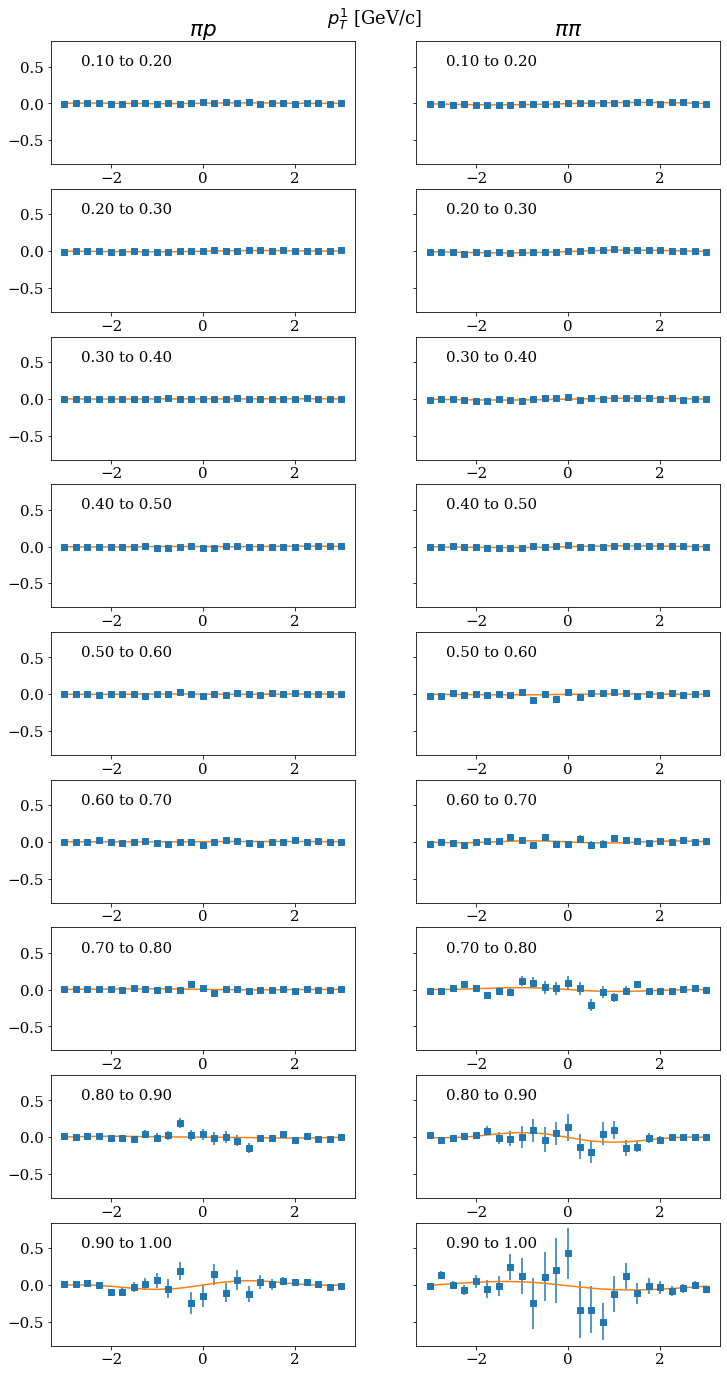

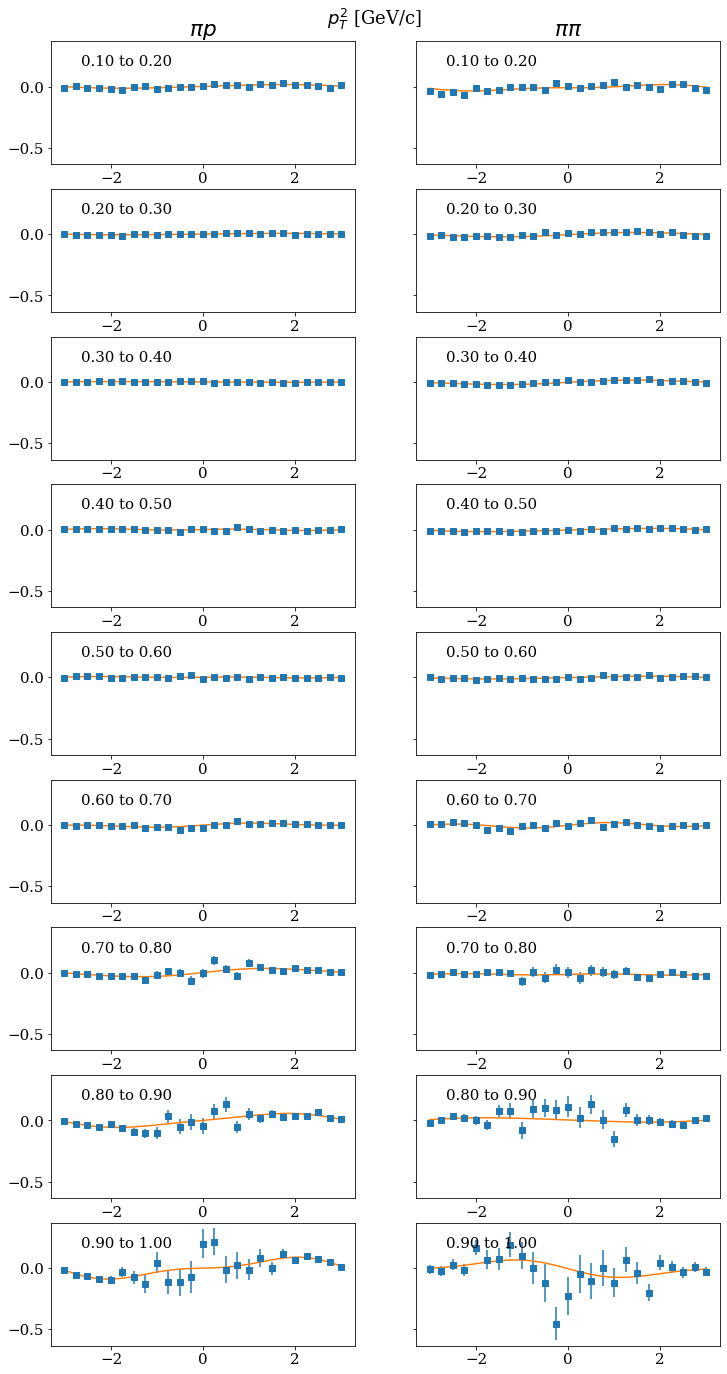

In [27]:

import misc_util
help(misc_util.BinIterator)




def masterplot(binvars,xlbls,filename):
    bins = 25
    queries = ['h2_pid==2212 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1',
            'abs(h2_pid)==211 and diff_rap_cm>1.5 and diff_rap_cm<2.5 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1']
    labels = ['$\pi p$', '$\pi\pi$']



    nr = len(binvars)
    nc = len(binvars[0])
    fig,axs = plt.subplots(nr,nc, figsize=(14,8),sharey='all')
    fig.subplots_adjust(hspace=0.3)
    for row in range(nr):
        for col in range(nc):
            fig2,axs2 = plt.subplots(9,2, figsize=(12,24), sharey='all')
            for ii in [0,1]:
                xs,ys,dys = [],[],[]
                q0 = queries[ii]

                jj = 0
                for x, df in misc_util.BinIterator(data_dihadrons.query(q0),
                                                   *binvars[row][col]):
                    phi,a,da= asym1d(df)
                    (p0,p1,p2),cov = sin2phifit(phi,a,da)
                    print(p1, cov[1][1])
                    if p1 == 1 or p1 == 0:
                        continue
                    axs2[jj][ii].errorbar(phi[da<1],a[da<1], da[da<1], linestyle='',label='$\pi p$',marker='s')

                    axs2[jj][ii].plot(phi,p0+p1*np.sin(phi)+p2*np.sin(2*phi))
                    v = df[binvars[row][col][0]]
                    axs2[jj][ii].text(0.1, 0.8,"%.2f to %.2f" % (min(v),max(v)), transform = axs2[jj][ii].transAxes)


                    xs.append(x)
                    ys.append(p1)
                    dys.append(np.sqrt(cov[1][1]))
                    jj+=1
                axs[row][col].errorbar(xs,ys,dys,label=labels[ii])
                axs[row][col].set_xlabel(xlbls[row][col])
            axs[row][col].axhline(0,linestyle=':',alpha=0.5,color="0.5")
            if(col == 0):
                axs[row][0].set_ylabel("$<\\sin \\Delta\\phi>$")
            fig2.suptitle(xlbls[row][col],y=0.9)
            axs2[0][0].set_title("$\pi p$")
            axs2[0][1].set_title("$\pi\pi$")
            fig2.savefig("../images/asym1d_slices_%s.pdf" % (binvars[row][col][0]),bbox_inches='tight')
            fig2.show()
    axs[0][0].legend()
    axs[0][0].text(1.5, 0.15, "$1.5<\Delta y < 2.5$")
    fig.savefig(filename,bbox_inches='tight')
    fig.show()
    
binvars = [[('Q2',1, 7,6), ('x',0, 1,9)],[('h1_cm_pt',.1,1,9),('h2_cm_pt',.1,1,9)]]
xlbls = [["$Q^2$ [GeV$^2/c^2$]","$x_B$"],["$p^1_T$ [GeV/c]",'$p^2_T$ [GeV/c]']]
filename= "../images/asym1d_sin_vs_Q2_etc.pdf"
masterplot(binvars,xlbls,filename)

0.0 0.0
1.0 inf
1.0 inf
-0.0305391097786508 0.0009716865067682878


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.02357101647808677 6.534884636908368e-05
0.016829708490637096 7.0883852965691754e-06
0.016602354410430016 1.0511657346903274e-06
0.007358907913633333 7.521849804995534e-07
-0.0026002139763706155 2.3504673906316383e-06
-0.013246871366417863 6.160599043838883e-06
0.1483083237513867 0.002879879597858943
0.03053654734980133 0.00011080136737856233
0.019352889497340077 9.471882547770172e-06
0.01336816265398138 3.5090867940008993e-06
0.008238426860930388 1.095486694835727e-06
0.007508092644983504 7.527064758417619e-07
0.007936704489327722 6.6723127016447e-07
0.014972555039873716 1.402838347815334e-06
0.012129369808926996 1.0051189712887023e-05
0.00434296097466498 5.193608447595365e-05


NameError: name 'row' is not defined

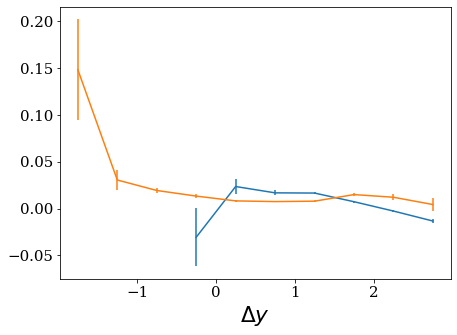

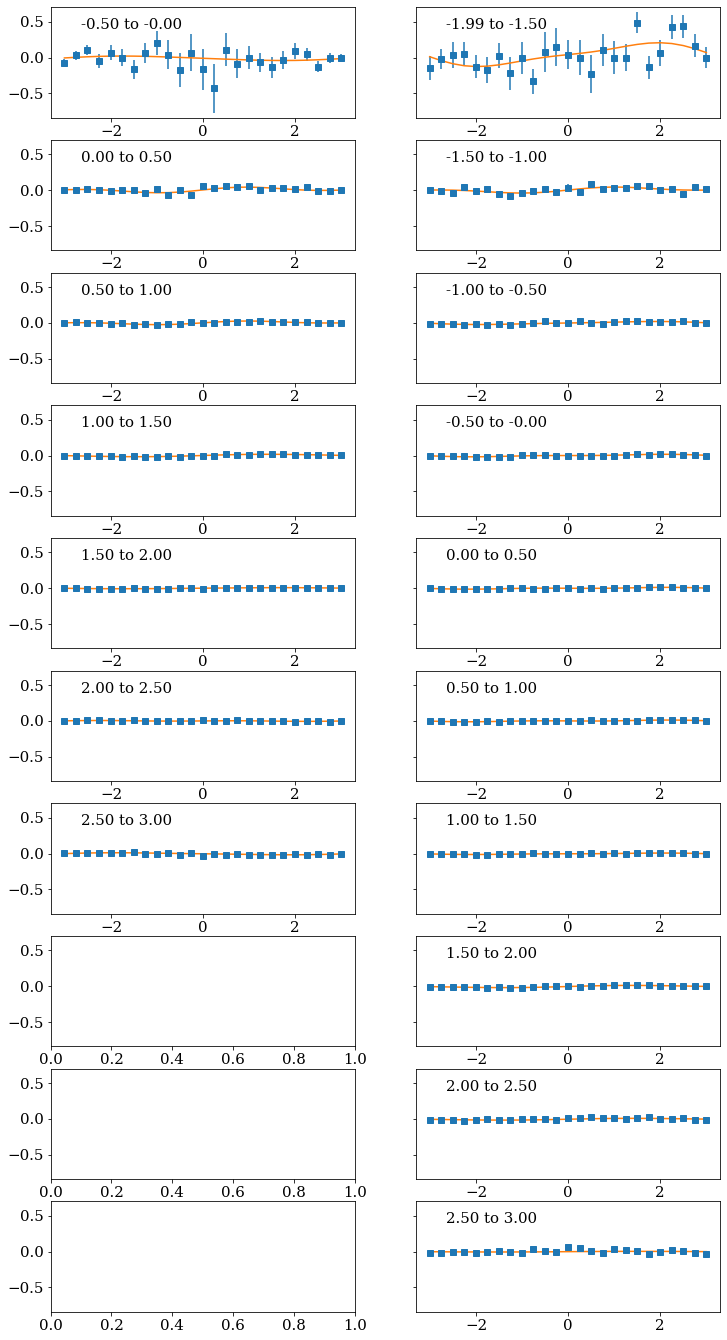

In [28]:
bins = 25

fig,ax = plt.subplots(1,1, figsize=(7,5),sharey='all')
fig.subplots_adjust(hspace=0.3)

queries = ['h2_pid==2212 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1',
            'abs(h2_pid)==211 and h1_cm_pt > 0.1 and h2_cm_pt > 0.1']
labels = ['$\pi p$', '$\pi\pi$']

binvar =('diff_rap_cm',-2, 3,10)
xlbl = "$\Delta y$"

fig2,axs2 = plt.subplots(10,2, figsize=(12,24), sharey='all')
for ii in [0,1]:
    xs,ys,dys = [],[],[]
    q0 = queries[ii]
    jj = 0
    for x, df in misc_util.BinIterator(data_dihadrons.query(q0),
                                       *binvar):
        phi,a,da= asym1d(df)
        #axs[0].errorbar(phi,a, da, linestyle='',label='$\pi p$',marker='s')
        (p0,p1,p2),cov = sin2phifit(phi,a,da)
        print(p1, cov[1][1])
        if p1 == 1 or p1 == 0:
            continue
            
        axs2[jj][ii].errorbar(phi[da<1],a[da<1], da[da<1], linestyle='',label='$\pi p$',marker='s')

        axs2[jj][ii].plot(phi,p0+p1*np.sin(phi)+p2*np.sin(2*phi))
        v = df[binvar[0]]
        axs2[jj][ii].text(0.1, 0.8,"%.2f to %.2f" % (min(v),max(v)), transform = axs2[jj][ii].transAxes)
        xs.append(x)
        ys.append(p1)
        dys.append(np.sqrt(cov[1][1]))
        jj+=1
    ax.errorbar(xs,ys,dys,label=labels[ii])
    ax.set_xlabel(xlbl)
    
fig2.suptitle(xlbls[row][col],y=0.9)
axs2[0][0].set_title("$\pi p$")
axs2[0][1].set_title("$\pi\pi$")
fig2.savefig("../images/asym1d_slices_%s.pdf" % (binvar[0]),bbox_inches='tight')
fig2.show()

ax.axhline(0,linestyle=':',alpha=0.5,color="0.5")
ax.set_ylabel("$<\\sin \\Delta\\phi>$")
ax.legend()
#ax.text(-1, 0.045, "$1.5<\Delta y < 2.5$")

plt.savefig("../images/asym1d_sin_vs_dy.pdf",bbox_inches='tight')